In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.svm import SVC


## Data Preparation

### Data Loading

In [2]:
#load df_windows
df_windows = pd.read_csv('../data/df_windows.csv')
df_windows1 = pd.read_csv('../data/df_windows_1.csv')
df_windows0 = pd.read_csv('../data/df_windows_0.csv')
df_windows_2 = pd.read_csv('../data/df_windows_2.csv')

print(f"Number of events : Number of events : {len(df_windows)}, Number of No event : {len(df_windows0)}, Number of Minor events : {len(df_windows1)}, Number of Major events : {len(df_windows_2)}")

In [14]:
#drop column IPLA, Distances, Shot, window, time_window
data = df_windows.drop(columns=['IPLA','ECEcore','ZMAG','LI', 'distances', 'window', 'time_window'])
data = data.drop(columns=['instability_x_current'])

validation_shot = 95467
#create data_val that takes the 1 validation shot
data_val = data[data['shot'] == validation_shot]

#take the shot out of data
data = data[data['shot'] != validation_shot]

data.head(5)


,distance_mean,minor_events,ECEcore_mean,ECEcore_dx1,ECEcore_dx2,ZMAG_mean,LI_mean,fft_low,shot,label,...,IPLA_ddx,IPLA_1,IPLA_2,IPLA_3,IPLA_4,IPLA_mean,Vloop_1,Vloop_2,Vloop_3,Vloop_4
0,-56307.483333,0.0,2822.7430,6.463867,-0.354248,0.342851,1.150685,2.885532e+07,81206,0,...,-2330.6250,1922563.1,1924126.80,1922741.80,1923580.8,1923687.9,-1.036661,-2.111309,-1.613139,-0.717432
1,-47580.700000,0.0,1955.4099,14.115967,-14.139160,0.355247,1.253791,2.927879e+07,81206,0,...,-3192.1250,1951248.2,1952237.00,1952226.20,1950999.0,1951919.2,-3.662136,-1.286469,-1.223850,-1.472519
2,-10166.108333,0.0,1770.3937,11.359497,4.013428,0.303880,1.191489,2.984001e+07,81206,0,...,1529.2500,1988619.6,1987009.50,1989410.00,1989018.2,1989334.0,-0.956687,-0.584253,-1.086478,-0.400202
3,-30771.841667,0.0,1824.6714,16.383667,0.000000,0.256757,1.147373,2.953092e+07,81206,0,...,-56.6250,1969271.8,1968408.60,1969010.90,1967915.2,1968728.4,-0.877379,-0.743979,-0.696189,-1.513505
4,64155.254167,0.0,1735.4666,0.000000,0.000000,0.197556,1.834007,9.361791e+06,81206,0,...,-5759.1875,622110.1,623452.44,624908.25,624267.8,624119.3,1.871721,1.500065,0.527328,0.995674


In [17]:
# Create a df X which contains all data columns except for the Label and shot column
X = data.drop(columns=['label','shot'])

# Create a df y which contains only the label column
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## SVM

### Choosing the kernel

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    clf = make_pipeline(StandardScaler(), SVC(kernel=kernel,class_weight='balanced'))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(kernel)
    print(accuracy_score(y_test, y_pred))
    print(f1_score(y_test, y_pred, average='macro'))
    print(classification_report(y_test, y_pred))



linear
0.96045197740113
0.8847103726986978
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       130
           1       0.91      0.91      0.91        34
           2       0.82      0.69      0.75        13

    accuracy                           0.96       177
   macro avg       0.90      0.87      0.88       177
weighted avg       0.96      0.96      0.96       177

poly
0.9322033898305084
0.8296447622290319
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       130
           1       0.88      0.82      0.85        34
           2       0.88      0.54      0.67        13

    accuracy                           0.93       177
   macro avg       0.90      0.79      0.83       177
weighted avg       0.93      0.93      0.93       177

rbf
0.9378531073446328
0.8374088374088373
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       130
 

We see that Linear and RBF have the best results so we decide to hyperparameter tune them. Linear kernel also offers feature importance variables to easily plot which features matter (not avaible for RBF for example).

### Linear SVM optimization with hyperparameter tuning

In [23]:
#perform an optimized SVM linear with scaler and weight balancing and cross validation
# Create a parameter grid
param_grid = {'svc__C': [0.1,1,2,0.5],
              'svc__gamma': [0.0001,0.00001,0.0002]}

# Create a pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='linear', random_state=42))])

# Create a stratified k-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a grid search object with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=skf, return_train_score=True)

# Fit the grid search
grid.fit(X_train, y_train)


# View the best parameters and score
print('Best C:', grid.best_estimator_.get_params()['svc__C'])
print('Best gamma:', grid.best_estimator_.get_params()['svc__gamma'])
print('Best score:', grid.best_score_)
print('Best estimator:', grid.best_estimator_)

# View the best estimator
best_svm_model = grid.best_estimator_

# Predict the target value
y_pred = best_svm_model.predict(X_test)

# View the classification report
print(classification_report(y_test, y_pred))
print(f"ACCURACY : {metrics.accuracy_score(y_test, y_pred)}")
print(f"F1 SCORE {metrics.f1_score(y_test, y_pred,average='weighted')}")


Best C: 1
Best gamma: 0.0001
Best score: 0.9603935670762163
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=1, gamma=0.0001, kernel='linear', random_state=42))])
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       130
           1       0.89      0.94      0.91        34
           2       1.00      0.69      0.82        13

    accuracy                           0.97       177
   macro avg       0.96      0.88      0.91       177
weighted avg       0.97      0.97      0.96       177

ACCURACY : 0.9661016949152542
F1 SCORE 0.9645746412986675


Best C: 1
Best gamma: 0.001
ACCURACY : 0.9661016949152542
F1 SCORE 0.9645746412986675

### Feature analysis

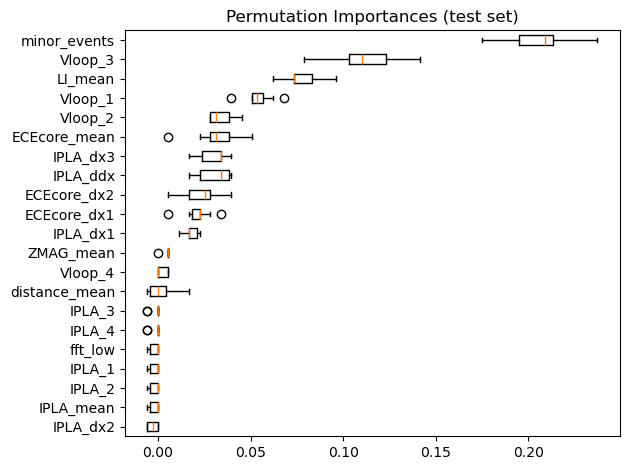

In [24]:
#measure feature importance
result = permutation_importance(best_svm_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

<Axes: >

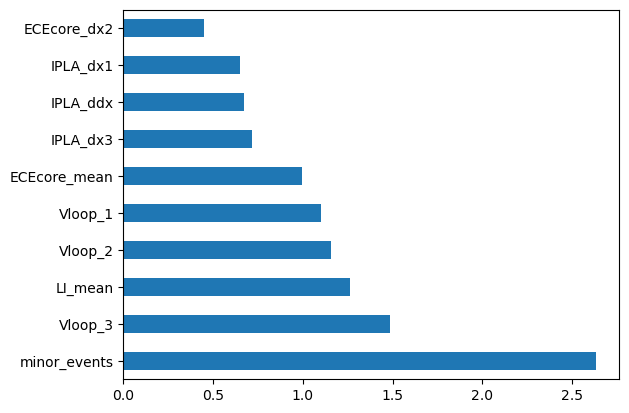

In [25]:
#get svm out of the best_svm_model
svm = best_svm_model['svc']
pd.Series(abs(svm.coef_[0]), index=X.columns).nlargest(10).plot(kind='barh')

### Overfitting analysis

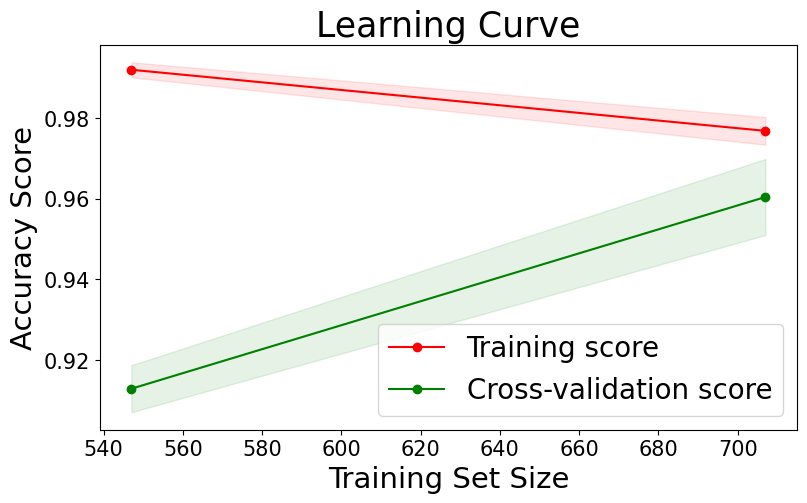

Best training score: 0.9766615591481911
Best cross-validation score: 0.9603935670762163


In [26]:
train_sizes, train_scores, test_scores = learning_curve(
    grid.best_estimator_, X, y, cv=skf, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(9, 5))  # Set the figure size

plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color="g", alpha=0.1)

# Plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve", fontsize=25)
plt.xlabel("Training Set Size", fontsize=21)
plt.ylabel("Accuracy Score", fontsize=21)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="best", fontsize=20)

plt.show()
cv_results = grid.cv_results_
mean_train_score = cv_results['mean_train_score'][grid.best_index_]
mean_cv_score = cv_results['mean_test_score'][grid.best_index_]

print('Best training score:', mean_train_score)
print('Best cross-validation score:', mean_cv_score)

We see that the difference between training accuracy and test accuracy is not enough to justify overfitting. The model seems to be performing well on Train and Test without overfitting

### Optimize Poly kernel

In [27]:
# Create a parameter grid
param_grid = {'svc__C': [1,10,40,100],
              'svc__gamma': [0.5,0.1,0.3,0.005],
              'svc__degree': [2,3,4,5],}
# Create a pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='poly', random_state=42,class_weight='balanced'))])

# Create a stratified k-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a grid search object with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=skf, return_train_score=True)

# Fit the grid search
grid.fit(X_train, y_train)


# View the best parameters and score
print('Best C:', grid.best_estimator_.get_params()['svc__C'])
print('Best gamma:', grid.best_estimator_.get_params()['svc__gamma'])
print('Best score:', grid.best_score_)
print('Best estimator:', grid.best_estimator_)

# View the best estimator
best_svm_model = grid.best_estimator_

# Predict the target value
y_pred = best_svm_model.predict(X_test)

# View the classification report
print(classification_report(y_test, y_pred))
print(f"ACCURACY : {metrics.accuracy_score(y_test, y_pred)}")
print(f"F1 SCORE {metrics.f1_score(y_test, y_pred,average='weighted')}")


Best C: 100
Best gamma: 0.1
Best score: 0.9405553890720206
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=100, class_weight='balanced', degree=4, gamma=0.1,
                     kernel='poly', random_state=42))])
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       130
           1       0.81      0.88      0.85        34
           2       0.89      0.62      0.73        13

    accuracy                           0.94       177
   macro avg       0.89      0.83      0.85       177
weighted avg       0.94      0.94      0.94       177

ACCURACY : 0.9378531073446328
F1 SCORE 0.9361385218350505


Best C: 1
Best gamma: 0.1
ACCURACY : 0.9615384615384616
F1 SCORE 0.9615384615384616

### Optimize RBF kernel

In [28]:
# Create a parameter grid
param_grid = {'svc__C': [10,20,30,40,50,80,94,100,110,120],
              'svc__gamma': [0.0002,0.0003,0.0004, 0.0005, 0.0006, 0.0007],}
# Create a pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', random_state=42, class_weight='balanced'))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a grid search object with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=skf, return_train_score=True)

# Fit the grid search
grid.fit(X_train, y_train)

# View the best parameters and score
print('Best C:', grid.best_estimator_.get_params()['svc__C'])
print('Best gamma:', grid.best_estimator_.get_params()['svc__gamma'])
print('Best kernel:', grid.best_estimator_.get_params()['svc__kernel'])
print('Best score:', grid.best_score_)
print('Best estimator:', grid.best_estimator_)

# View the best estimator
best_svm_model = grid.best_estimator_

# Predict the target value
y_pred = best_svm_model.predict(X_test)

# View the classification report
print(classification_report(y_test, y_pred))
print(f"ACCURACY : {metrics.accuracy_score(y_test, y_pred)}")
print(f"F1 SCORE {metrics.f1_score(y_test, y_pred, average='weighted')}")


Best C: 94
Best gamma: 0.0005
Best kernel: rbf
Best score: 0.9702826890420537
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=94, class_weight='balanced', gamma=0.0005,
                     random_state=42))])
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       130
           1       0.89      0.94      0.91        34
           2       1.00      0.77      0.87        13

    accuracy                           0.97       177
   macro avg       0.96      0.90      0.92       177
weighted avg       0.97      0.97      0.97       177

ACCURACY : 0.9661016949152542
F1 SCORE 0.9655130465437177


Best C: 94
Best gamma: 0.0005
ACCURACY : 0.9661016949152542
F1 SCORE 0.9655130465437177

#### Plot best param

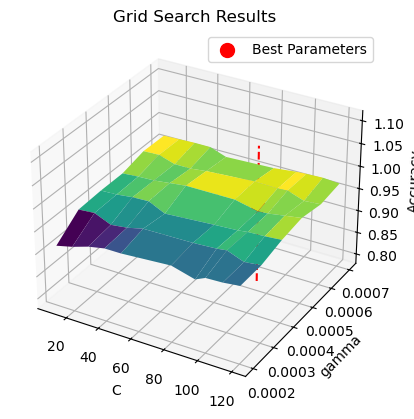

<Figure size 640x480 with 0 Axes>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# Get the grid search results
results = grid.cv_results_
param_grid = grid.param_grid

# Extract the hyperparameters and scores
n_estimators = param_grid['svc__C']
max_depth = param_grid['svc__gamma']
scores = results['mean_test_score']

# Create a meshgrid for the hyperparameters
n_estimators_mesh, max_depth_mesh = np.meshgrid(n_estimators, max_depth)

# Reshape the scores to match the meshgrid shape
scores_mesh = scores.reshape(max_depth_mesh.shape)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(n_estimators_mesh, max_depth_mesh, scores_mesh, cmap='viridis')

# Get the best hyperparameters
best_params = grid.best_params_
best_C = best_params['svc__C']
best_gamma = best_params['svc__gamma']
best_score = grid.best_score_

# Plot the point for the best parameters
ax.scatter(best_C, best_gamma, best_score, color='red', s=100, label='Best Parameters')
ax.plot([best_C, best_C], [best_gamma, best_gamma], [0.8, 1.1], color='red', linestyle='--')

# Set labels and title
ax.set_xlabel('C')
ax.set_ylabel('gamma')
ax.set_zlabel('Accuracy')
ax.set_title('Grid Search Results')
#ax.view_init(elev=30, azim=100)
#ax.view_init(elev=10, azim=90)

# Add a legend
ax.legend()

# Show the plot
plt.show()
plt.savefig('../figures/gridsearch_SVM.png')

#### Feature importance RBF

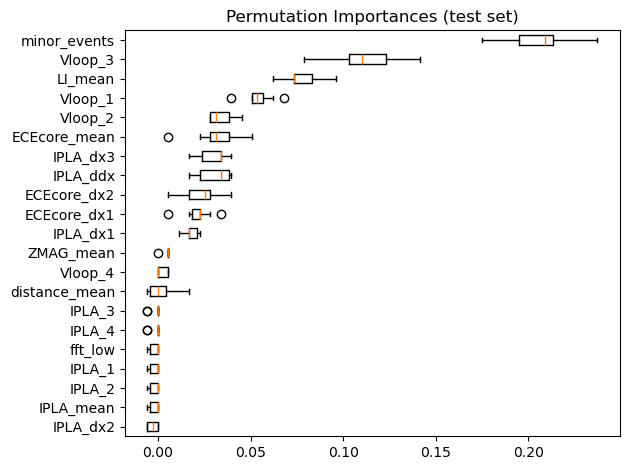

In [ ]:
#measure feature importance
result = permutation_importance(best_svm_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

#### Output probabilities of SVM RBF

The following code allows to output the probabilities per class for the predictions.

In [29]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', random_state=42, class_weight='balanced',gamma=0.0005, C=94, probability=True))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

probabilities = pipe.predict_proba(X_test)
y_test = np.array(y_test)
print(f'Window sample Probabilities : {probabilities[100]}, Predicted label : {y_pred[100]}, Correct label : {y_test[100]}')

0.9661016949152542
0.9655130465437177
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       130
           1       0.89      0.94      0.91        34
           2       1.00      0.77      0.87        13

    accuracy                           0.97       177
   macro avg       0.96      0.90      0.92       177
weighted avg       0.97      0.97      0.97       177

Window sample Probabilities : [0.00723413 0.95363969 0.03912618], Predicted label : 1, Correct label : 1


### Validation Shot

In [30]:
X_val = data_val.drop(columns=['label','shot'])
y_val = data_val['label']
y_pred = best_svm_model.predict(X_val)

print(classification_report(y_val, y_pred))
print(f"ACCURACY : {metrics.accuracy_score(y_val, y_pred)}")
print(f"F1 SCORE {metrics.f1_score(y_val, y_pred,average='macro')}")

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.75      0.86         8
           2       1.00      1.00      1.00         2

    accuracy                           0.87        15
   macro avg       0.90      0.92      0.90        15
weighted avg       0.90      0.87      0.87        15

ACCURACY : 0.8666666666666667
F1 SCORE 0.8968253968253967


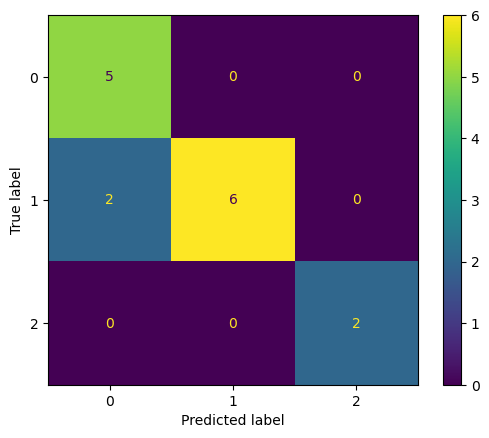

In [31]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create the ConfusionMatrixDisplay object and plot the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
